### discrepancy in the GAMA photometry between `InputCatA.fits` and `kcorr`
There's a significant discrepancy in the GAMA photometry between two different catalogs in GAMA DR2. `Jon Loveday` suggested that this was likely due to extinction correction. Check that this resolves the issue. 


__update__: yes, it resolves all the issues.

In [7]:
import numpy as np 
from astropy.io import fits
# -- local -- 
import env
from feasibgs import util as UT
from ChangTools.fitstables import mrdfits
from ChangTools.fitstables import FitsTable

In [4]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

### Read in the following GAMA data:
- `InputCatA.fits`
- `kcorr_z00.fits`
- `kcorr_z01.fits`
- `GalacticExtinction.fits`

In [8]:
def readKcorr(fitsfile):
    ''' kcorrect file has some issue that requires 
    special reading in
    '''
    kcorr = FitsTable()
    
    f = fits.open(fitsfile)
    f.verify('fix')
    fitsdata = f[1].data
    for name in fitsdata.names: 
        setattr(kcorr, name.lower(), fitsdata.field(name))
    return kcorr

In [68]:
gama_input = mrdfits(UT.dat_dir()+'gama/InputCatA.fits')
gama_tile = mrdfits(UT.dat_dir()+'gama/TilingCat.fits')
gama_kcorr0 = readKcorr(UT.dat_dir()+'gama/kcorr_z00.fits')
gama_kcorr1 = readKcorr(UT.dat_dir()+'gama/kcorr_z01.fits')
gama_galext = mrdfits(UT.dat_dir()+'gama/GalacticExtinction.fits')

 [astropy.io.fits.verify]
 [astropy.io.fits.verify]


first lets illustrate the issue

In [13]:
bands = ['u', 'g', 'r', 'i', 'z']

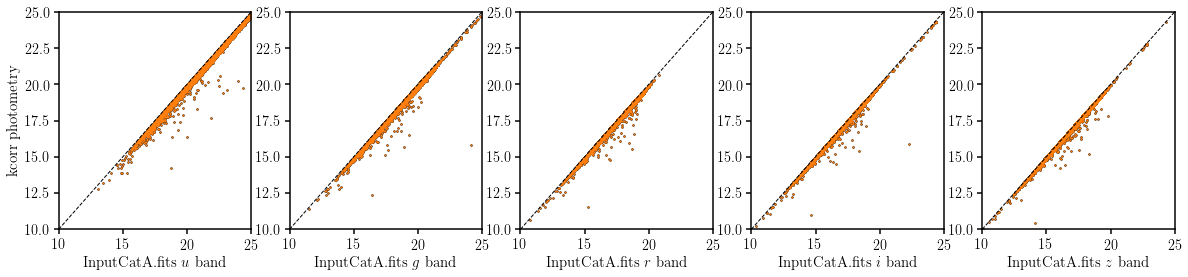

In [51]:
fig = plt.figure(figsize=(4*len(bands), 4))
for i_b, b in enumerate(bands): 
    sub = fig.add_subplot(1,len(bands),i_b+1)
    sub.scatter(getattr(gama_input, 'modelmag_'+b)[gama_kcorr0.cataid], getattr(gama_kcorr0, b+'_model'), c='k', s=2)
    sub.scatter(getattr(gama_input, 'modelmag_'+b)[gama_kcorr1.cataid], getattr(gama_kcorr1, b+'_model'), c='C1', s=1)
    sub.plot([10.,25.], [10., 25.], c='k', lw=1, ls='--')
    sub.set_xlabel(('InputCatA.fits $%s$ band' % b), fontsize=15)
    sub.set_xlim([10., 25.])
    if i_b == 0: 
        sub.set_ylabel('kcorr photometry', fontsize=15)
    sub.set_ylim([10., 25.])

match all the objects together

In [71]:
print gama_kcorr0.cataid
print gama_tile.cataid

[  6802   6806   6808 ... 751313 751319 751324]
[  6802   6803   6804 ... 960506 960507 960508]


In [77]:
i_input = [] 
i_tile = [] 
i_galext = []
i_kcorr0 = []
for i in range(1000): 
    ingalext = np.where(gama_galext.cataid == gama_kcorr0.cataid[i])
    intile = np.where(gama_tile.cataid == gama_kcorr0.cataid[i])
    if len(ingalext[0]) < 1: continue
    elif len(ingalext[0]) > 1: raise ValueError
    if len(intile[0]) < 1: continue
    elif len(intile[0]) > 1: raise ValueError
    i_galext.append(ingalext[0][0])
    i_tile.append(intile[0][0])
    i_kcorr0.append(i)
    i_input.append(gama_kcorr0.cataid[i])

In [78]:
i_input = np.array(i_input)
i_tile = np.array(i_tile)
i_galext = np.array(i_galext)
i_kcorr0 = np.array(i_kcorr0)

Check that the matches are correct

In [79]:
assert np.array_equal(gama_input.cataid[i_input], gama_galext.cataid[i_galext])
assert np.array_equal(gama_input.cataid[i_input], gama_kcorr0.cataid[i_kcorr0])
assert np.array_equal(gama_input.cataid[i_input], gama_tile.cataid[i_tile])
assert np.array_equal(gama_galext.cataid[i_galext], gama_kcorr0.cataid[i_kcorr0])

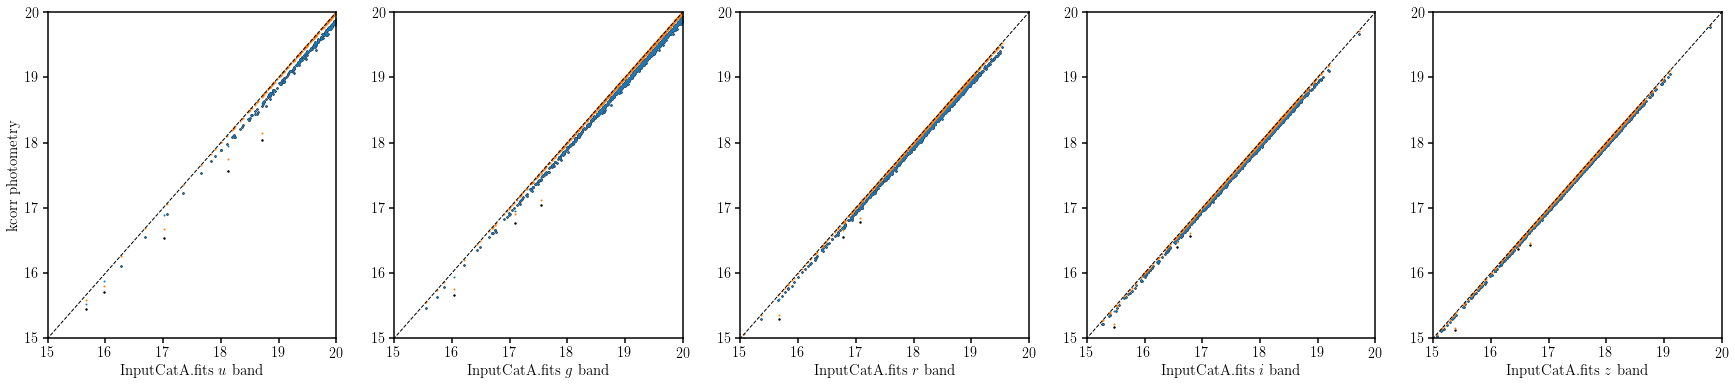

In [83]:
fig = plt.figure(figsize=(6*len(bands), 6))
for i_b, b in enumerate(bands): 
    sub = fig.add_subplot(1,len(bands),i_b+1)
    sub.scatter(getattr(gama_input, 'modelmag_'+b)[i_input], getattr(gama_kcorr0, b+'_model')[i_kcorr0], c='k', s=2)
    sub.scatter(getattr(gama_input, 'modelmag_'+b)[i_input], getattr(gama_tile, b+'_model')[i_tile], c='C0', s=1)
    sub.scatter(getattr(gama_input, 'modelmag_'+b)[i_input], 
                getattr(gama_kcorr0, b+'_model')[i_kcorr0] + getattr(gama_galext, 'a_'+b)[i_galext], c='C1', s=1)
    sub.plot([10.,25.], [10., 25.], c='k', lw=1, ls='--')
    sub.set_xlabel(('InputCatA.fits $%s$ band' % b), fontsize=15)
    sub.set_xlim([15., 20.])
    if i_b == 0: 
        sub.set_ylabel('kcorr photometry', fontsize=15)
    sub.set_ylim([15., 20.])

In [87]:
for b in bands: 
    print('%s band ======' % b)
    print (getattr(gama_input, 'modelmag_'+b)[i_input] - getattr(gama_galext, 'a_'+b)[i_galext])[:5]
    print getattr(gama_tile, b+'_model')[i_tile][:5]
    print getattr(gama_kcorr0, b+'_model')[i_kcorr0][:5]

u band ======
[20.167622 20.649433 22.161324 15.526285 19.091429]
[20.167622 20.649431 22.161327 15.526284 19.091433]
[20.16762161 20.64943123 22.16132736 15.4528688  19.09143257]
g band ======
[19.111954 19.605257 19.989815 14.873034 17.908897]
[19.111956 19.605257 19.989817 14.873034 17.908897]
[19.11195564 19.60525703 19.98981667 14.83492779 17.9088974 ]
r band ======
[18.64841  18.531977 18.763508 14.747663 17.491882]
[18.648415 18.531971 18.76351  14.74766  17.491879]
[18.64841461 18.53197098 18.76350975 14.71390343 17.49187851]
i band ======
[18.365662 18.151999 18.29372  14.792967 17.124557]
[18.365664 18.151997 18.293718 14.792962 17.12456 ]
[18.36566353 18.15199661 18.29371834 14.76463168 17.1245594 ]
z band ======
[18.19646  17.768347 17.998873 14.715539 16.971506]
[18.196466 17.768345 17.998875 14.715544 16.971502]
[18.19646645 17.76834488 17.99887466 14.68824636 16.9715023 ]


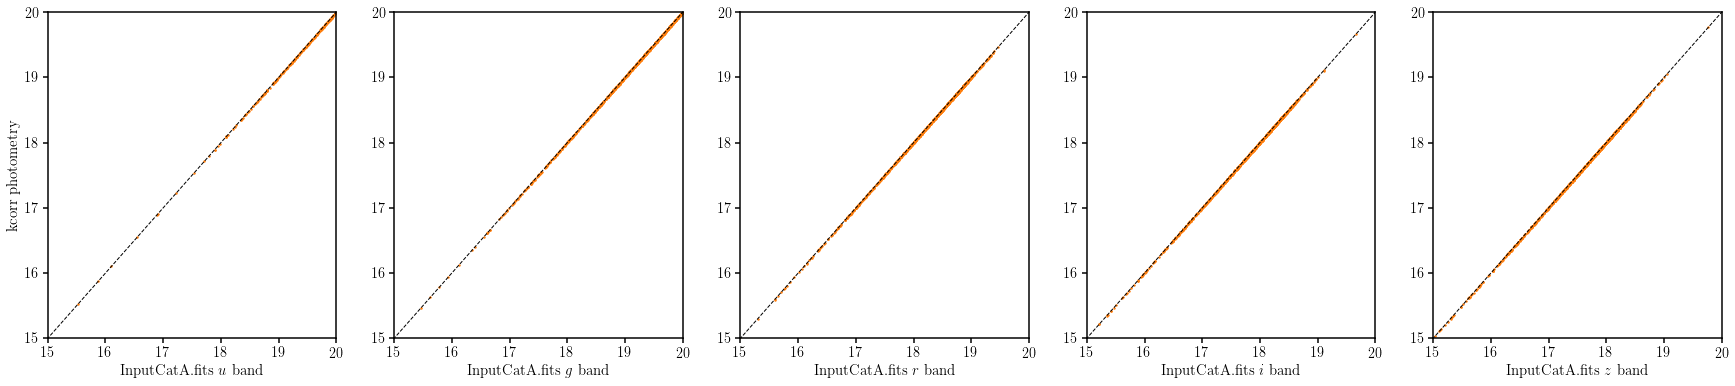

In [90]:
fig = plt.figure(figsize=(6*len(bands), 6))
for i_b, b in enumerate(bands): 
    sub = fig.add_subplot(1,len(bands),i_b+1)
    sub.scatter(getattr(gama_input, 'modelmag_'+b)[i_input] - getattr(gama_galext, 'a_'+b)[i_galext], getattr(gama_tile, b+'_model')[i_tile], c='C1', s=2)
    sub.plot([10.,25.], [10., 25.], c='k', lw=1, ls='--')
    sub.set_xlabel(('InputCatA.fits $%s$ band' % b), fontsize=15)
    sub.set_xlim([15., 20.])
    if i_b == 0: 
        sub.set_ylabel('kcorr photometry', fontsize=15)
    sub.set_ylim([15., 20.])

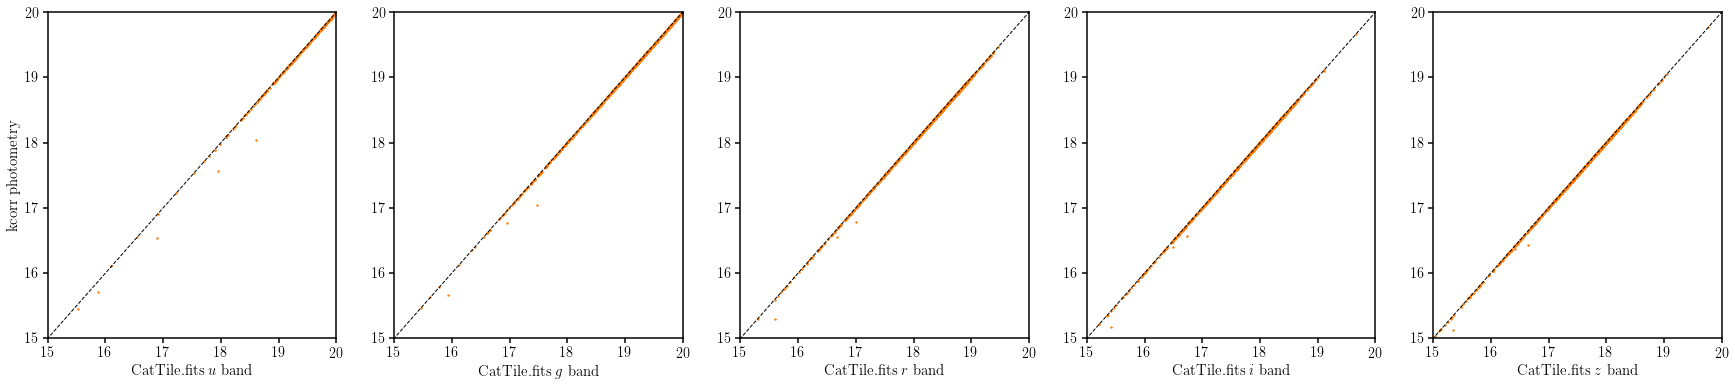

In [92]:
fig = plt.figure(figsize=(6*len(bands), 6))
for i_b, b in enumerate(bands): 
    sub = fig.add_subplot(1,len(bands),i_b+1)
    sub.scatter(getattr(gama_tile, b+'_model')[i_tile], getattr(gama_kcorr0, b+'_model')[i_kcorr0], c='C1', s=2)
    sub.plot([10.,25.], [10., 25.], c='k', lw=1, ls='--')
    sub.set_xlabel(('CatTile.fits $%s$ band' % b), fontsize=15)
    sub.set_xlim([15., 20.])
    if i_b == 0: 
        sub.set_ylabel('kcorr photometry', fontsize=15)
    sub.set_ylim([15., 20.])

In [112]:
for b in bands: 
    print getattr(gama_galext, 'a_'+b)[i_galext][:10] - (getattr(gama_input, 'modelmag_'+b)[i_input] - getattr(gama_tile, b+'_model')[i_tile])[:10]

[ 9.3877316e-07 -1.8179417e-06  4.2691827e-06 -7.0035458e-07
  3.8072467e-06  1.6242266e-06  3.0770898e-06  2.8610229e-06
  2.8833747e-06  3.4049153e-06]
[ 2.6822090e-06  4.7683716e-07  2.1234155e-06 -8.1956387e-08
 -2.4586916e-07  9.5367432e-07  1.0058284e-06  4.6566129e-06
  2.8759241e-06 -3.9711595e-06]
[ 3.7811697e-06 -5.4016709e-06  2.5480986e-06 -2.6151538e-06
 -3.6396086e-06 -2.7678907e-06 -3.8370490e-06  3.2782555e-07
  1.5124679e-06 -2.7082860e-06]
[ 2.0302832e-06 -2.1159649e-06 -2.8014183e-06 -4.5150518e-06
  1.0132790e-06 -4.5187771e-06  3.9152801e-06  9.7230077e-07
  3.1329691e-06  3.6023557e-06]
[ 5.1856041e-06 -2.4735928e-06  2.5369227e-06  4.4927001e-06
 -3.6470592e-06 -3.2410026e-07 -2.0340085e-06  2.1904707e-06
  4.2952597e-06 -8.4191561e-07]


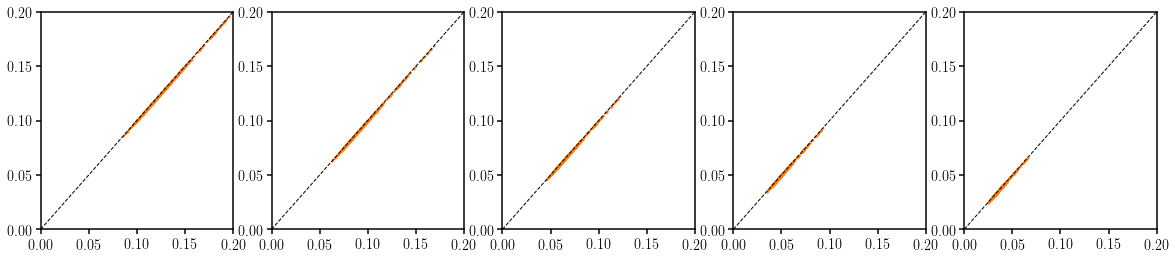

In [119]:
fig = plt.figure(figsize=(4*len(bands), 4))
for i_b, b in enumerate(bands): 
    sub = fig.add_subplot(1,len(bands),i_b+1)
    A_band = getattr(gama_galext, 'a_'+b)[i_galext]
    dphoto = (getattr(gama_input, 'modelmag_'+b)[i_input] - getattr(gama_tile, b+'_model')[i_tile])
    sub.scatter(A_band, dphoto, c='C1', s=1)
    
    #sub.scatter((getattr(gama_input, 'modelmag_'+b)[i_input] - getattr(gama_tile, b+'_model')[i_tile])[:100], #getattr(gama_kcorr0, b+'_model')[i_kcorr0],
    #            getattr(gama_galext, 'a_'+b)[i_galext][:100],
    #            c='C1', s=2)
    sub.plot([0.,0.5], [0., 0.5], c='k', lw=1, ls='--')
    #sub.set_xlabel(('InputCatA.fits $%s$ band' % b), fontsize=15)
    sub.set_xlim([0., 0.2])
    #if i_b == 0: 
    #    sub.set_ylabel('kcorr photometry', fontsize=15)
    sub.set_ylim([0., 0.2])